🔄 Carregando df a partir da tabela storage_audit…
✅ df criado com 23883 registros.
🔎 DataFrame de imagens: 23871 arquivos.


/tmp/ipykernel_14388/975251793.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(



🚀 Processando 10 imagens…


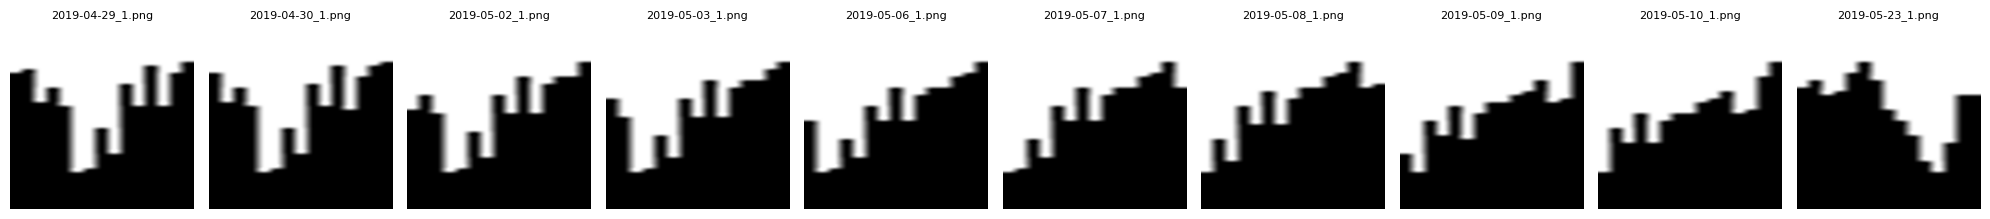


✅ Processamento concluído.


In [6]:
# =======================================================================
# Notebook Test Cell – Curadoria de Imagens (subset de 10 arquivos)
# Corrige ausência da coluna `tipo` na tabela storage_audit
# =======================================================================

# --- 0. CONFIGURAÇÕES ----------------------------------------------------
PG_HOST     = "database-services"   # serviço PostgreSQL no docker-compose
PG_USER     = "postgres"
PG_PASSWORD = "senhasegura"
PG_DB       = "postgres"            # ajuste se for diferente
PREFIXO     = "FDL"                 # prefixo/projeto a filtrar
LIMITE      = 10                    # nº de imagens para o teste

# --- 1. (Re)CRIA O DATAFRAME PRINCIPAL -----------------------------------
try:
    df  # já existe?
    print("✅ Variável df já carregada na memória.")
except NameError:
    import pandas as pd, psycopg2, pathlib
    print("🔄 Carregando df a partir da tabela storage_audit…")
    conn = psycopg2.connect(
        host=PG_HOST,
        user=PG_USER,
        password=PG_PASSWORD,
        dbname=PG_DB,
    )
    df = pd.read_sql(
        """
        SELECT
            filename,
            full_path AS full_
        FROM   storage_audit
        WHERE  prefix = %s
        """,
        conn,
        params=(PREFIXO,),
    )
    conn.close()
    print(f"✅ df criado com {len(df)} registros.")

    # — cria coluna `tipo` por extensão -----------------------------------
    def classificar(ext):
        ext = ext.lower()
        if ext in {".png", ".jpg", ".jpeg", ".gif", ".bmp"}:
            return "imagem"
        elif ext in {".csv", ".xls", ".xlsx", ".parquet"}:
            return "numerico"
        elif ext in {".txt", ".pdf", ".md"}:
            return "texto"
        else:
            return "outro"

    df["tipo"] = df["filename"].apply(lambda x: classificar(pathlib.Path(x).suffix))

# --- 2. FILTRA SOMENTE IMAGENS -------------------------------------------
df_cardapio_imagem = df[df["tipo"] == "imagem"].copy()
print(f"🔎 DataFrame de imagens: {len(df_cardapio_imagem)} arquivos.")

# --- 3. FUNÇÃO DE PROCESSAMENTO ------------------------------------------
from minio import Minio
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import os, sys

def processar_imagem_cardapio(
    df_cardapio_imagem,
    prefixo=PREFIXO,
    limite=LIMITE,
    bucket_origem="storage-unique",
    bucket_destino="curated-test",
):
    """Baixa, redimensiona e salva um subset de imagens no MinIO."""
    total = min(limite, len(df_cardapio_imagem))
    if total == 0:
        print("⚠️  Nenhuma imagem encontrada para o prefixo fornecido.")
        return

    print(f"\n🚀 Processando {total} imagens…")

    client = Minio(
        "minio:9000",
        access_key="admin",
        secret_key="senhasegura",
        secure=False,
    )

    if not client.bucket_exists(bucket_destino):
        client.make_bucket(bucket_destino)

    subset = df_cardapio_imagem.head(limite)

    fig, axes = plt.subplots(1, total, figsize=(20, 4))
    if total == 1:
        axes = [axes]

    for i, (_, row) in enumerate(subset.iterrows()):
        objeto = row["full_"]               # caminho dentro de storage-unique
        nome   = os.path.basename(objeto)

        try:
            data = client.get_object(bucket_origem, objeto).read()
            img  = Image.open(BytesIO(data)).convert("RGB")

            # —— transformação de exemplo ————————————————
            img_resized = img.resize((224, 224))

            # —— salva no bucket de teste ————————————————
            buf = BytesIO()
            img_resized.save(buf, format="PNG")
            buf.seek(0)

            destino = f"{prefixo}/{nome}"
            client.put_object(
                bucket_destino,
                destino,
                data=buf,
                length=buf.getbuffer().nbytes,
                content_type="image/png",
            )

            # —— exibição inline ————————————————
            axes[i].imshow(img_resized)
            axes[i].axis("off")
            axes[i].set_title(nome, fontsize=8)

        except Exception as e:
            print(f"⚠️  Erro em {objeto}: {e}", file=sys.stderr)

    plt.tight_layout()
    plt.show()
    print("\n✅ Processamento concluído.")

# --- 4. EXECUTA O PROCESSO -----------------------------------------------
processar_imagem_cardapio(df_cardapio_imagem)


In [7]:
# %% [markdown]
# ## Passo 0 – Configuração Inicial da Curadoria
# 
# Esta célula realiza:
# - Conexão com o MinIO (`minio:9000`)
# - Criação do bucket `curated-unique`, se necessário
# - Conexão com o PostgreSQL (`postgres_db:5432`)
# - Criação da tabela `curation_audit`, se ainda não existir

# %%
import os
from datetime import datetime

from minio import Minio
from minio.error import S3Error
import psycopg2
from psycopg2 import sql

# -------------------------------
# Configurações e credenciais
# -------------------------------
MINIO_ENDPOINT   = "minio:9000"
MINIO_ACCESS_KEY = "admin"
MINIO_SECRET_KEY = "senhasegura"
BUCKET_CURATED   = "curated-unique"

PG_HOST     = "postgres_db"
PG_PORT     = 5432
PG_DB       = "postgres"
PG_USER     = "postgres"
PG_PASSWORD = "senhasegura"

# -------------------------------
# 1. Cliente MinIO + Criação do Bucket
# -------------------------------
client = Minio(
    MINIO_ENDPOINT,
    access_key=MINIO_ACCESS_KEY,
    secret_key=MINIO_SECRET_KEY,
    secure=False,
)

try:
    if not client.bucket_exists(BUCKET_CURATED):
        client.make_bucket(BUCKET_CURATED)
        print(f"🪣 Bucket '{BUCKET_CURATED}' criado.")
    else:
        print(f"🪣 Bucket '{BUCKET_CURATED}' já existe.")
except S3Error as err:
    raise RuntimeError(f"Erro ao acessar/criar bucket: {err}") from err

# -------------------------------
# 2. Conexão PostgreSQL + Criação da Tabela
# -------------------------------
create_table_stmt = """
CREATE TABLE IF NOT EXISTS curation_audit (
    id              SERIAL PRIMARY KEY,
    filename        TEXT        NOT NULL,
    project         TEXT        NOT NULL,
    tipo            TEXT        NOT NULL,
    status          TEXT        NOT NULL,
    processed_at    TIMESTAMPTZ NOT NULL DEFAULT NOW()
);
"""

with psycopg2.connect(
    host=PG_HOST, port=PG_PORT, dbname=PG_DB,
    user=PG_USER, password=PG_PASSWORD
) as conn:
    with conn.cursor() as cur:
        cur.execute(create_table_stmt)
        conn.commit()
        print("📑 Tabela 'curation_audit' pronta (ou já existia).")

print("\n✅ Passo 0 concluído — ambiente pronto para curadoria.")


🪣 Bucket 'curated-unique' já existe.
📑 Tabela 'curation_audit' pronta (ou já existia).

✅ Passo 0 concluído — ambiente pronto para curadoria.


In [ ]:
# %% [markdown]
# ## Passo 1 (definitivo) – Carregar imagens a partir da view `storage_com_origem`
# - Filtro por extensão (.png, .jpg, .jpeg)
# - Extração do tipo de dado via regex do caminho
# - Preparação para curadoria real

# %%
import pandas as pd
import psycopg2
import re

# -------------------------------
# 1. Conexão e carregamento
# -------------------------------
query = "SELECT * FROM storage_com_origem ORDER BY storage_id ASC;"

with psycopg2.connect(
    host=PG_HOST, port=PG_PORT, dbname=PG_DB,
    user=PG_USER, password=PG_PASSWORD
) as conn:
    df_storage = pd.read_sql(query, conn)

print(f"🔎 View carregada com {len(df_storage)} registros.")

# -------------------------------
# 2. Filtro por imagem
# -------------------------------
extensoes_validas = (".png", ".jpg", ".jpeg")
df_imagens = df_storage[df_storage["filename"].str.lower().str.endswith(extensoes_validas)].copy()

# -------------------------------
# 3. Extração do tipo a partir do caminho
# -------------------------------
def extrair_tipo(caminho):
    match = re.search(r'/([^/]+)/[^/]+$', caminho)
    return match.group(1) if match else "desconhecido"

df_imagens["tipo"] = df_imagens["caminho_minio"].apply(extrair_tipo)

# -------------------------------
# 4. Visualização
# -------------------------------
display(df_imagens.head(3))
print("📊 Contagem por tipo de imagem:")
print(df_imagens["tipo"].value_counts())

print(f"\n✅ Passo 1 concluído — {len(df_imagens)} imagens preparadas para curadoria.")


🔎 View carregada com 0 registros.


/tmp/ipykernel_14388/1366284044.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_storage = pd.read_sql(query, conn)


,storage_id,filename,bucket,hash_sha256,diretorio_origem,caminho_relativo,nome_arquivo,caminho_minio,data_processamento,tipo


📊 Contagem por tipo de imagem:
Series([], Name: count, dtype: int64)

✅ Passo 1 concluído — 0 imagens preparadas para curadoria.


: 